In [1]:
########################################
# Imports
########################################
from firedrake import *
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd  # OB2025: alias for timing utilities (not used below)
import numpy as np  # OB2025: numerical utilities; used for np.power in boundary term
import matplotlib   # OB2025: plotting backend (not used below)


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
########################################
# Mesh and Coordinates
########################################
m  = 20              # number of 1D mesh cells (elements) along y
Ly = 0.85            # domain length in y-direction
dy = Ly/m            # uniform cell size (mesh spacing) in y
mesh = IntervalMesh(m, 0 , Ly)  # 1D mesh from y=0 to y=Ly with m cells
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh)   # continuous spatial coordinate function y on the mesh


In [3]:

########################################
# Time Definitions
########################################
t   = 0.0            # current simulation time
end = 150.0          # final simulation time
Ntm = 75             # number of measurement/diagnostic outputs
dtmeas = end/Ntm     # interval between outputs
tmeas = dtmeas       # next output time threshold


In [4]:
########################################
# Function Space
########################################
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3: Higher order leades to oscillations for theta=0
nCG = 1                # polynomial degree for CG space
V = FunctionSpace(mesh, "CG", nCG)   # scalar continuous Galerkin space P^nCG on mesh


In [5]:
########################################
# Timestep
########################################
CFL = 2.3                          # stability/control factor used to set timestep
Dt = CFL*0.5*dy*dy                 # explicit-like dt estimate ~ O(dy^2); used as fixed step here
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt)                  # Firedrake Constant for dt used in variational forms


In [6]:
########################################
# Time Discretization
########################################
theta = 0                  # time discretization parameter: 0=explicit, 1/2=CN, 1=implicit


In [7]:
########################################
# Physical Constants and Case Selection
########################################
mpor  = 0.3                        # effective porosity (-)
sigma = 0.8                        # storativity/porosity scaling (-)
Lc    = 0.05                       # characteristic canal width/length scale (m)
kperm = 1e-8                       # permeability (m^2)
w     = 0.1                        # canal width (m) [not used downstream]
R     = 0.000125                   # recharge/source term (m/s)
nu    = 1.0e-6                     # kinematic viscosity of water (m^2/s)
g     = 9.81                       # gravitational acceleration (m/s^2)
alpha = kperm/( nu * mpor * sigma )  # hydraulic diffusivity coefficient in PDE
gam   = Lc/( mpor*sigma )            # canal-storage coupling coefficient
fac2  = sqrt(g)/( mpor*sigma )       # weir-law prefactor in boundary flux
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
nncase = 1                         # selects boundary condition model (0: Dirichlet, 1: weir-law)


In [8]:
########################################
# Initial Condition
########################################
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
h_prev = Function(V).interpolate(0.0 + 0.0*y)  # initial groundwater head h^n (flat zero field)


In [9]:
########################################
# Output
########################################
outfile = VTKFile("./Results/groundwater_alexcarey.pvd")  # PVD output file for Paraview

outfile.write(h_prev , t = t )   # write initial state at t=0


In [10]:
########################################
# Variational Forms
########################################
# h will be the equivalent to h^n+1 in our timestepping scheme

phi = TestFunction(V)            # test function for variational formulation

def flux ( h , phi , R ):        # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )


In [11]:
## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

########################################
# Boundary Conditions and Solvers

# Possible Formulations:
# nncase = 0: Dirichlet BC at y=Ly
# nncase = 1: Weir-law BC at y=0 coupling to canal section
# Possible time discretisation given Weir-law BC:
# theta = 0: explicit/IMEX time stepping
# theta = 0.5: Crank-Nicholson time stepping
# theta = 1: implicit time stepping
########################################
if nncase == 0:
    # Provide intial guess to non linear solve
     h = Function(V)                                       # unknown groundwater head at new time
     h.assign(h_prev)                                      # initial guess for nonlinear iteration
     F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx  # residual form
    # Boundary conditions: Condition at Ly satisfied weakly
     bc1 = DirichletBC(V, 0.07, 1)                        # Dirichlet head at boundary id 1 (y=Ly)
     h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)  # nonlinear variational problem

elif nncase == 1:
   if theta == 0.0: # Matches (31)
      h, out = TrialFunction(V), Function(V)              # trial (unknown) and solution storage for linear step
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)             # left-hand side bilinear form with canal coupling
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R) ) *dx # interior right-hand side using previous step
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29): boundary RHS with weir law
      explicit_problem = LinearVariationalProblem(aa, L, out)  # linear problem for explicit theta=0
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij', 
          'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})  # direct solve
   elif theta > 0.0: # Matches (30) when theta=1/2
      h = Function(V)                                     # unknown groundwater head at new time
      h.assign(h_prev)                                    # start Newton iteration from previous head
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx  # interior residual
      # Add boundary contributions at y = 0: 
      F2 = ( gam*phi*(h-h_prev)/dt
                + theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)
                + (1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)  # weir-law boundary flux
      h_problem = NonlinearVariationalProblem( F+F2 , h )         # nonlinear problem with boundary term
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})  # direct Newton linearization solve


In [12]:
end = 200

In [13]:
########################################
# Time Loop
########################################
ys = np.linspace(0,Ly,100)  
values: list[list] = []
times: list = []
while (t < end):
    # First we increase time
    t += Dt                                  # advance time by fixed step
    # Use the solver and then update values for next timestep
    if theta == 0.0:
        explicit_solver.solve()            # solve linear explicit/IMEX step
        h_prev.assign(out)                # update stored head with new solution
    elif theta > 0.0:
        h_solver.solve()                  # solve nonlinear step (e.g., CN/implicit)
        h_prev.assign(h)                  # update stored head with new solution
    # Write output to file for paraview visualisation
    if t>tmeas:
     print('Time is: ',t)                 # periodic progress output
     times.append(t)
     values.append([h_prev.at(x) for x in ys])
     tmeas = tmeas+dtmeas                 # schedule next output time
     outfile.write(h_prev , t = t )       # write field to Paraview file
# End while time loop

Time is:  2.000331562500031


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  4.000663124999892
Time is:  6.00099468750018
Time is:  8.001326250000467
Time is:  10.0016578124999
Time is:  12.001989374999333
Time is:  14.000243749998766
Time is:  16.0005753124982
Time is:  18.000906874997632
Time is:  20.001238437497065
Time is:  22.001569999996498
Time is:  24.00190156249593
Time is:  26.000155937495364
Time is:  28.000487499994797
Time is:  30.00081906249423
Time is:  32.00115062499366
Time is:  34.001482187493096
Time is:  36.00181374999253
Time is:  38.00006812499196
Time is:  40.000399687491395
Time is:  42.00073124999083
Time is:  44.00106281249026
Time is:  46.001394374989694
Time is:  48.00172593748913
Time is:  50.00205749998856
Time is:  52.00031187498799
Time is:  54.000643437487426
Time is:  56.00097499998686
Time is:  58.00130656248629
Time is:  60.001638124985725
Time is:  62.00196968748516
Time is:  64.00022406248459
Time is:  66.00055562499087
Time is:  68.00088718749714
Time is:  70.00121875000342
Time is:  72.00155031250969
Time is:  7

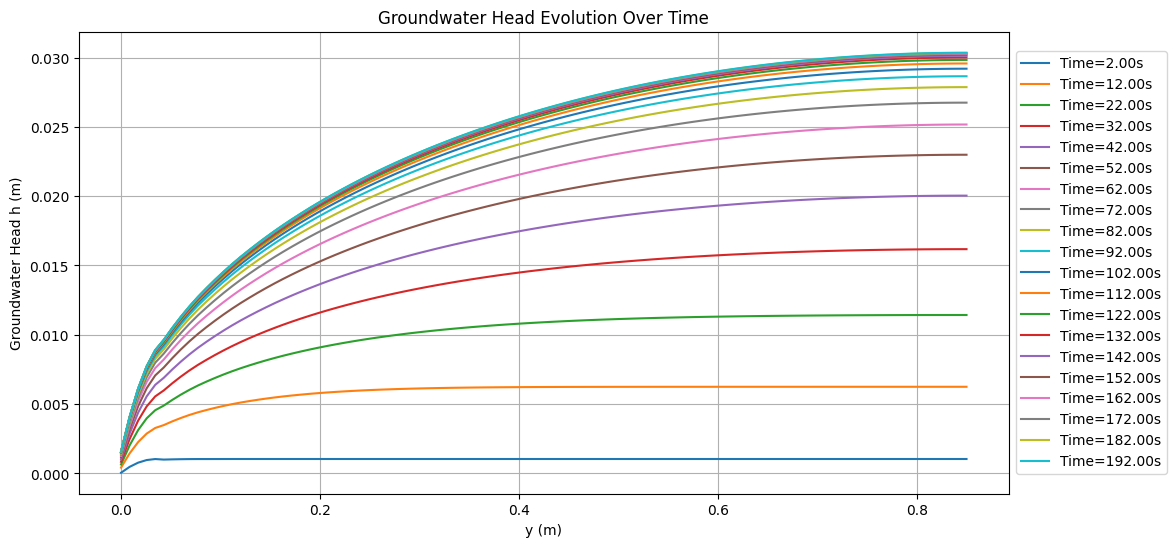

In [100]:
import matplotlib.pyplot as plt
# Set plot width and height
plt.figure(figsize=(12, 6))
for i in range(0, len(times), 5):
    plt.plot(ys, values[i], label=f'Time={times[i]:.2f}s')
plt.xlabel('y (m)')
plt.ylabel('Groundwater Head h (m)')
plt.title('Groundwater Head Evolution Over Time')
# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.show()

# Heatmap plot with horizontal axis as y and vertical axis as time
# import matplotlib.pyplot as plt

# Y, T = np.meshgrid(ys, times)
# Z = np.array(values)
# plt.figure(figsize=(8, 6))
# plt.contourf(Y, T, Z, levels=50, cmap='viridis')
# plt.colorbar(label='Groundwater Head h (m)')
# plt.xlabel('y (m)')
# plt.ylabel('Time (s)')
# plt.title('Groundwater Head Evolution Over Time')
# plt.show()

# # Plot final state as steady state profile
# plt.plot(ys, values[-1], label=f'Time={times[-1]:.2f}s')
# plt.xlabel('y (m)')
# plt.ylabel('Groundwater Head h (m)')
# plt.title('Final Groundwater Head Profile')
# plt.legend()
# plt.grid()
# plt.show()

# # Plot just the state at y = 0 through time
# plt.figure(figsize=(8, 6))
# h_at_y0 = [value[0] for value in values]
# plt.plot(times, h_at_y0, marker='o')
# plt.xlabel('Time (s)')
# plt.ylabel('Groundwater Head h at y=0 (m)')
# plt.title('Groundwater Head at y=0 Over Time')
# plt.grid()
# plt.show()

# print("Final canal height (y=0) is h =", h_at_y0[-1], "m at time t =", times[-1], "s")


In [15]:
########################################
# Imports
########################################
from firedrake import *
# packages Working code as of May 14th 2018 by Will Booker and Onno Bokhove
# import numpy as np
from math import pow
import time as tijd  # OB2025: alias for timing utilities (not used below)
import numpy as np  # OB2025: numerical utilities; used for np.power in boundary term
import matplotlib   # OB2025: plotting backend (not used below)


In [16]:
########################################
# Mesh and Coordinates
########################################
m  = 20              # number of 1D mesh cells (elements) along y
Ly = 0.85            # domain length in y-direction
dy = Ly/m            # uniform cell size (mesh spacing) in y
mesh = IntervalMesh(m, 0 , Ly)  # 1D mesh from y=0 to y=Ly with m cells
# OB2025 y = mesh.coordinates # OB2025 Mesh coordinates
y, = SpatialCoordinate(mesh)   # continuous spatial coordinate function y on the mesh


In [17]:

########################################
# Time Definitions
########################################
t   = 0.0            # current simulation time
end = 150.0          # final simulation time
Ntm = 75             # number of measurement/diagnostic outputs
dtmeas = end/Ntm     # interval between outputs
tmeas = dtmeas       # next output time threshold


In [18]:
########################################
# Function Space
########################################
# Initially we will use a continuous linear Lagrange basis
# Try other order, 1, 2, 3
nCG = 2             # polynomial degree for CG space
V = FunctionSpace(mesh, "CG", nCG)   # scalar continuous Galerkin space P^nCG on mesh


In [19]:
########################################
# Timestep
########################################
CFL = 2.3                          # stability/control factor used to set timestep
Dt = CFL*0.5*dy*dy                 # explicit-like dt estimate ~ O(dy^2); used as fixed step here
# Dt = 16*Dt
# dt.assign(CFL*0.5*dy*dy)

dt = Constant(Dt)                  # Firedrake Constant for dt used in variational forms


In [20]:
########################################
# Time Discretization
########################################
theta = 0.5                 # time discretization parameter: 0=explicit, 1/2=CN, 1=implicit


In [21]:
########################################
# Physical Constants and Case Selection
########################################
mpor  = 0.3                        # effective porosity (-)
sigma = 0.8                        # storativity/porosity scaling (-)
Lc    = 0.05                       # characteristic canal width/length scale (m)
kperm = 1e-8                       # permeability (m^2)
w     = 0.1                        # canal width (m) [not used downstream]
R     = 0.000125                   # recharge/source term (m/s)
nu    = 1.0e-6                     # kinematic viscosity of water (m^2/s)
g     = 9.81                       # gravitational acceleration (m/s^2)
alpha = kperm/( nu * mpor * sigma )  # hydraulic diffusivity coefficient in PDE
gam   = Lc/( mpor*sigma )            # canal-storage coupling coefficient
fac2  = sqrt(g)/( mpor*sigma )       # weir-law prefactor in boundary flux
# ncase = 0 Dirichlet bc, ncase = 1 overflow groundwater into canal section with weir equation:
nncase = 1                         # selects boundary condition model (0: Dirichlet, 1: weir-law)


In [22]:
########################################
# Initial Condition
########################################
# OB2025: h_prev = Function(V)
# OB2025 old stiff commented out: h_prev.interpolate(Expression("0.0"))
# OB2025
h_prev = Function(V).interpolate(0.0 + 0.0*y)  # initial groundwater head h^n (flat zero field)


In [23]:
########################################
# Output
########################################
outfile = VTKFile("./Results/groundwater_alexcarey.pvd")  # PVD output file for Paraview

outfile.write(h_prev , t = t )   # write initial state at t=0


In [24]:
########################################
# Variational Forms
########################################
# h will be the equivalent to h^n+1 in our timestepping scheme

phi = TestFunction(V)            # test function for variational formulation

def flux ( h , phi , R ):        # phi is test function q in (31) and (32)
    return ( alpha * g * h * dot ( grad (h) , grad (phi) ) - (R * phi )/ ( mpor * sigma ) )


In [25]:
## NB: Linear solves use TrialFunctions, non-linear solves use Functions with initial guesses.

########################################
# Boundary Conditions and Solvers

# Possible Formulations:
# nncase = 0: Dirichlet BC at y=Ly
# nncase = 1: Weir-law BC at y=0 coupling to canal section
# Possible time discretisation given Weir-law BC:
# theta = 0: explicit/IMEX time stepping
# theta = 0.5: Crank-Nicholson time stepping
# theta = 1: implicit time stepping
########################################
if nncase == 0:
    # Provide intial guess to non linear solve
     h = Function(V)                                       # unknown groundwater head at new time
     h.assign(h_prev)                                      # initial guess for nonlinear iteration
     F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx  # residual form
    # Boundary conditions: Condition at Ly satisfied weakly
     bc1 = DirichletBC(V, 0.07, 1)                        # Dirichlet head at boundary id 1 (y=Ly)
     h_problem = NonlinearVariationalProblem( F , h , bcs = bc1)  # nonlinear variational problem

elif nncase == 1:
   if theta == 0.0: # Matches (31)
      h, out = TrialFunction(V), Function(V)              # trial (unknown) and solution storage for linear step
      aa = (h*phi/dt)*dx+(gam*phi*h/dt)*ds(1)             # left-hand side bilinear form with canal coupling
      L2 = ( h_prev*phi/dt - flux ( h_prev, phi, R) ) *dx # interior right-hand side using previous step
      L = L2+( gam*phi*h_prev/dt-phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1) # Matches (29): boundary RHS with weir law
      explicit_problem = LinearVariationalProblem(aa, L, out)  # linear problem for explicit theta=0
      explicit_solver = LinearVariationalSolver(explicit_problem, solver_parameters={'mat_type':'aij', 
          'ksp_type': 'preonly', 'pc_type': 'lu', 'pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})  # direct solve
   elif theta > 0.0: # Matches (30) when theta=1/2
      h = Function(V)                                     # unknown groundwater head at new time
      h.assign(h_prev)                                    # start Newton iteration from previous head
      F = ( (h-h_prev)*phi/dt  + theta * flux ( h , phi , R ) + (1-theta)* flux ( h_prev, phi, R) ) *dx  # interior residual
      # Add boundary contributions at y = 0: 
      F2 = ( gam*phi*(h-h_prev)/dt
                + theta*phi*fac2*np.power(max_value(2.0*h/3.0,0.0),1.5)
                + (1-theta)*phi*fac2*max_value(2.0*h_prev/3.0,0.0)*sqrt(max_value(2.0*h_prev/3.0,0.0)) )*ds(1)  # weir-law boundary flux
      h_problem = NonlinearVariationalProblem( F+F2 , h )         # nonlinear problem with boundary term
      h_solver = NonlinearVariationalSolver(h_problem, solver_parameters={'mat_type':'aij','ksp_type':'preonly','pc_type':'lu','pc_factor_mat_solver_type': 'mumps','ksp_rtol': 1e-14})  # direct Newton linearization solve


In [26]:
end = 200

In [27]:
########################################
# Time Loop
########################################
ys = np.linspace(0,Ly,100)  
values: list[list] = []
times: list = []
while (t < end):
    # First we increase time
    t += Dt                                  # advance time by fixed step
    # Use the solver and then update values for next timestep
    if theta == 0.0:
        explicit_solver.solve()            # solve linear explicit/IMEX step
        h_prev.assign(out)                # update stored head with new solution
    elif theta > 0.0:
        h_solver.solve()                  # solve nonlinear step (e.g., CN/implicit)
        h_prev.assign(h)                  # update stored head with new solution
    # Write output to file for paraview visualisation
    if t>tmeas:
     print('Time is: ',t)                 # periodic progress output
     times.append(t)
     values.append([h_prev.at(x) for x in ys])
     tmeas = tmeas+dtmeas                 # schedule next output time
     outfile.write(h_prev , t = t )       # write field to Paraview file
# End while time loop

Time is:  2.000331562500031


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(
/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  4.000663124999892
Time is:  6.00099468750018
Time is:  8.001326250000467
Time is:  10.0016578124999
Time is:  12.001989374999333
Time is:  14.000243749998766
Time is:  16.0005753124982
Time is:  18.000906874997632
Time is:  20.001238437497065
Time is:  22.001569999996498
Time is:  24.00190156249593
Time is:  26.000155937495364
Time is:  28.000487499994797
Time is:  30.00081906249423
Time is:  32.00115062499366
Time is:  34.001482187493096
Time is:  36.00181374999253
Time is:  38.00006812499196
Time is:  40.000399687491395
Time is:  42.00073124999083
Time is:  44.00106281249026
Time is:  46.001394374989694
Time is:  48.00172593748913
Time is:  50.00205749998856
Time is:  52.00031187498799
Time is:  54.000643437487426
Time is:  56.00097499998686
Time is:  58.00130656248629
Time is:  60.001638124985725
Time is:  62.00196968748516
Time is:  64.00022406248459
Time is:  66.00055562499087
Time is:  68.00088718749714
Time is:  70.00121875000342
Time is:  72.00155031250969
Time is:  7

Time is:  126.0001165626791
Time is:  128.00044812518536
Time is:  130.00077968767795
Time is:  132.00111125017054
Time is:  134.00144281266313
Time is:  136.00177437515572
Time is:  138.00002875014832
Time is:  140.0003603126409
Time is:  142.0006918751335
Time is:  144.0010234376261
Time is:  146.00135500011868
Time is:  148.00168656261127
Time is:  150.00201812510386
Time is:  152.00027250009646
Time is:  154.00060406258905
Time is:  156.00093562508164
Time is:  158.00126718757423
Time is:  160.00159875006682
Time is:  162.0019303125594
Time is:  164.000184687552
Time is:  166.0005162500446
Time is:  168.0008478125372
Time is:  170.00117937502978
Time is:  172.00151093752237
Time is:  174.00184250001496
Time is:  176.00009687500756
Time is:  178.00042843750015
Time is:  180.00075999999274
Time is:  182.00109156248533


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  184.00142312497792
Time is:  186.0017546874705
Time is:  188.0000090624631
Time is:  190.0003406249557


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time is:  192.0006721874483
Time is:  194.00100374994088
Time is:  196.00133531243347
Time is:  198.00166687492606
Time is:  200.00199843741865


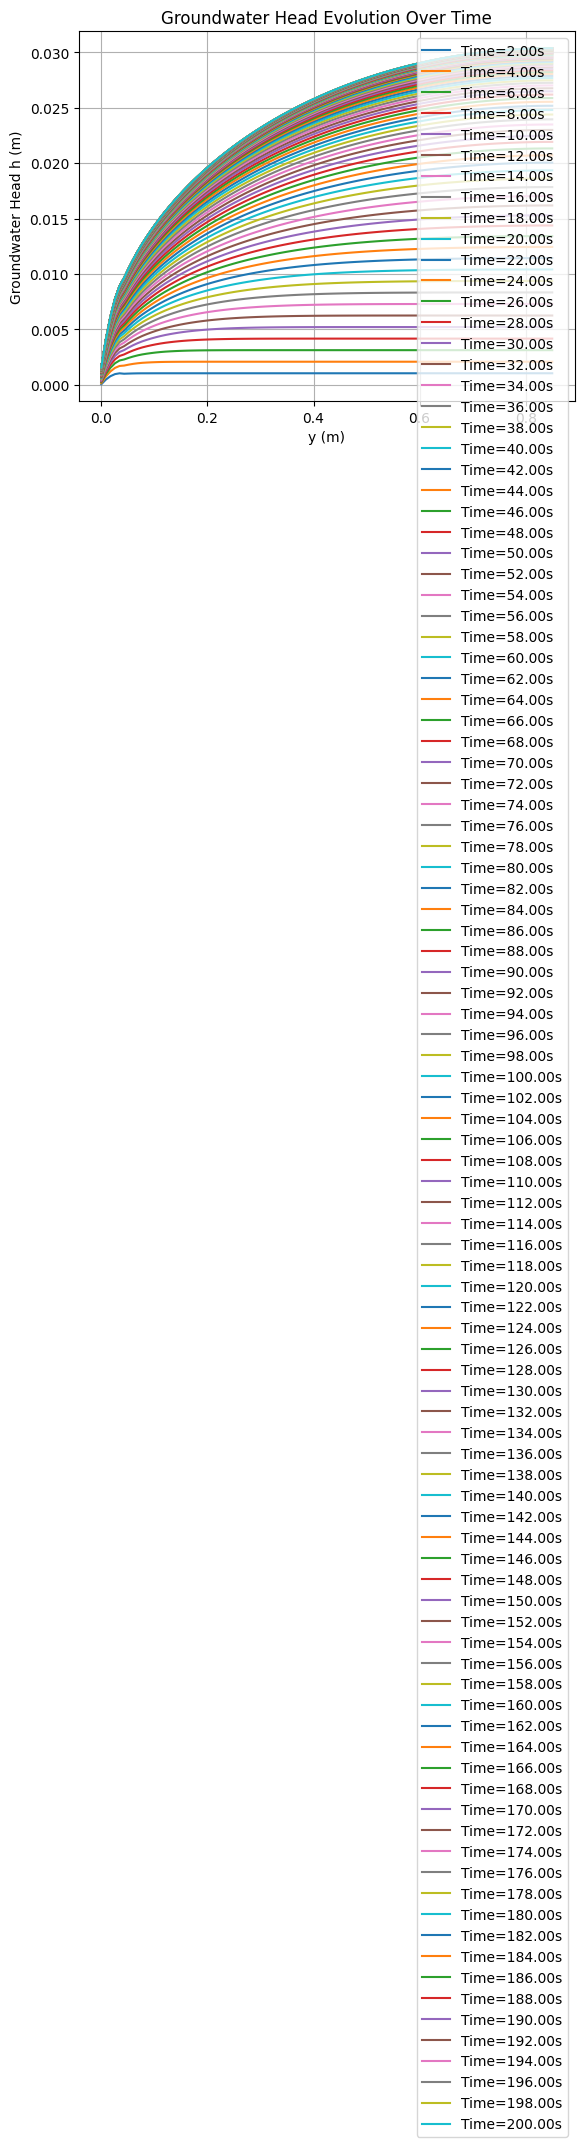

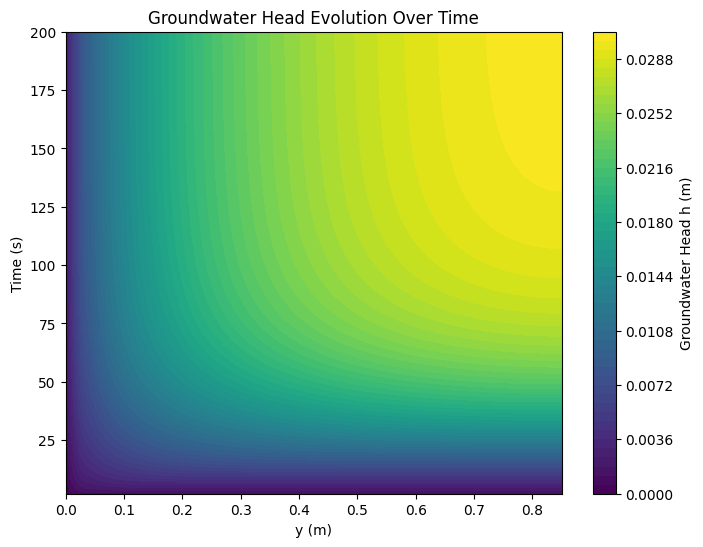

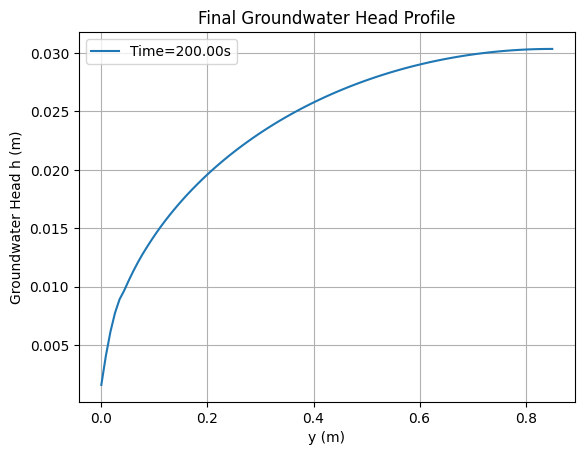

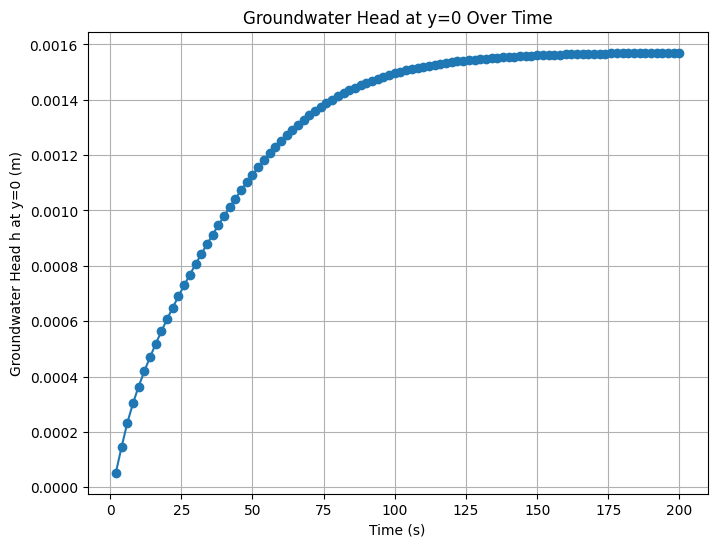

Final canal height (y=0) is h = 0.0015702223771748714 m at time t = 200.00199843741865 s


In [28]:
import matplotlib.pyplot as plt
for i in range(len(times)):
    plt.plot(ys, values[i], label=f'Time={times[i]:.2f}s')
plt.xlabel('y (m)')
plt.ylabel('Groundwater Head h (m)')
plt.title('Groundwater Head Evolution Over Time')
plt.legend()
plt.grid()
plt.show()

# Heatmap plot with horizontal axis as y and vertical axis as time
import matplotlib.pyplot as plt

Y, T = np.meshgrid(ys, times)
Z = np.array(values)
plt.figure(figsize=(8, 6))
plt.contourf(Y, T, Z, levels=50, cmap='viridis')
plt.colorbar(label='Groundwater Head h (m)')
plt.xlabel('y (m)')
plt.ylabel('Time (s)')
plt.title('Groundwater Head Evolution Over Time')
plt.show()

# Plot final state as steady state profile
plt.plot(ys, values[-1], label=f'Time={times[-1]:.2f}s')
plt.xlabel('y (m)')
plt.ylabel('Groundwater Head h (m)')
plt.title('Final Groundwater Head Profile')
plt.legend()
plt.grid()
plt.show()

# Plot just the state at y = 0 through time
plt.figure(figsize=(8, 6))
h_at_y0 = [value[0] for value in values]
plt.plot(times, h_at_y0, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Groundwater Head h at y=0 (m)')
plt.title('Groundwater Head at y=0 Over Time')
plt.grid()
plt.show()

print("Final canal height (y=0) is h =", h_at_y0[-1], "m at time t =", times[-1], "s")


# Variable Rainfall


In [29]:
# Reset simulation
h_prev.assign(Function(V).interpolate(0.0 + 0.0*y))

# Variable rainfall parameters
R_max = 0.000125                          # maximum rainfall rate (m/s)
rainfall_periods = [0, 1, 2, 4, 9, 10]        # possible rain durations (seconds)
rainfall_probabilities = [0.35, 0.3, 0.2, 0.1, 0.05, 0]  # probabilities for each duration
# rainfall_probabilities = [0, 0, 0, 0, 0, 1] # Recreation of the constant rainfall

# Time parameters
end = 50
t = 0.0
t_next_rain = 0.0  # next time to decide on rainfall
rain_end_time = 0.0  # when current rain period ends
tmeas = dtmeas
R_current = 0.0     # current rainfall rate

# Storage
ys_var = np.linspace(0, Ly, 100)  
values_var = []
times_var = []
Rs_var = []  # rainfall history

def build_solver(R_value):
    if theta == 0.0:
        h_trial, out_func = TrialFunction(V), Function(V)
        aa = (h_trial*phi/dt)*dx + (gam*phi*h_trial/dt)*ds(1)
        L2 = (h_prev*phi/dt - flux(h_prev, phi, R_value)) * dx
        L = L2 + (gam*phi*h_prev/dt - phi*fac2*max_value(2.0*h_prev/3.0, 0.0)*sqrt(max_value(2.0*h_prev/3.0, 0.0)))*ds(1)
        prob = LinearVariationalProblem(aa, L, out_func)
        solver = LinearVariationalSolver(prob, solver_parameters={
            'mat_type':'aij', 'ksp_type': 'preonly', 'pc_type': 'lu', 
            'pc_factor_mat_solver_type': 'mumps', 'ksp_rtol': 1e-14})
        return solver, out_func
    else:
        h_func = Function(V)
        h_func.assign(h_prev)
        F = ((h_func-h_prev)*phi/dt + theta*flux(h_func, phi, R_value) + (1-theta)*flux(h_prev, phi, R_value)) * dx
        F2 = (gam*phi*(h_func-h_prev)/dt 
              + theta*phi*fac2*np.power(max_value(2.0*h_func/3.0, 0.0), 1.5)
              + (1-theta)*phi*fac2*max_value(2.0*h_prev/3.0, 0.0)*sqrt(max_value(2.0*h_prev/3.0, 0.0)))*ds(1)
        prob = NonlinearVariationalProblem(F + F2, h_func)
        solver = NonlinearVariationalSolver(prob, solver_parameters={
            'mat_type':'aij', 'ksp_type':'preonly', 'pc_type':'lu',
            'pc_factor_mat_solver_type': 'mumps', 'ksp_rtol': 1e-14})
        return solver, h_func

# Build initial solver
current_solver, solution_func = build_solver(R_current)
rebuild_solver = False

print(f"Starting variable rainfall simulation (theta={theta})")
print(f"Rainfall checked every 10s, R_max={R_max} m/s")

Starting variable rainfall simulation (theta=0.5)
Rainfall checked every 10s, R_max=0.000125 m/s


In [30]:
# Time loop with variable rainfall
step = 0
while t < end:
    step += 1
    t += Dt
    
    # Check if it's time to decide on new rainfall
    if t >= t_next_rain:
        rain_period = np.random.choice(rainfall_periods, p=rainfall_probabilities)
        if rain_period > 0:
            R_new = R_max
            rain_end_time = t + rain_period
            print(f'Rain starts at t={t:.2f}s for {rain_period}s (until {rain_end_time:.2f}s)')
        else:
            R_new = 0.0
            rain_end_time = t
        t_next_rain += 10.0
        
        # Check if R changed, rebuild solver if needed
        if R_new != R_current:
            R_current = R_new
            rebuild_solver = True
    
    # Check if rain period ended
    if t >= rain_end_time and R_current > 0:
        print(f'Rain ends at t={t:.2f}s')
        R_current = 0.0
        rebuild_solver = True
    
    # Rebuild solver if R changed
    if rebuild_solver:
        current_solver, solution_func = build_solver(R_current)
        rebuild_solver = False
    
    # Solve
    current_solver.solve()
    h_prev.assign(solution_func)
    
    # Store rainfall status
    Rs_var.append(R_current)
    
    # Output
    if t > tmeas:
        print(f'Time: {t:.2f}s, Step: {step}, R: {R_current:.6f} m/s')
        times_var.append(t)
        values_var.append([h_prev.at(x) for x in ys_var])
        tmeas += dtmeas
        outfile.write(h_prev, t=t)

print(f"\\nSimulation complete! Total steps: {step}")

Time: 2.00s, Step: 963, R: 0.000000 m/s


/home/mm21ajc/PhD/Alex/venv-firedrake/lib/python3.12/site-packages/firedrake/function.py:556: FutureWarning: The ``Function.at`` method is deprecated and will be removed in a future release. Please use the ``PointEvaluator`` class instead.
  warnings.warn(


Time: 4.00s, Step: 1926, R: 0.000000 m/s
Time: 6.00s, Step: 2889, R: 0.000000 m/s
Time: 8.00s, Step: 3852, R: 0.000000 m/s
Rain starts at t=10.00s for 2s (until 12.00s)
Time: 10.00s, Step: 4815, R: 0.000125 m/s
Rain ends at t=12.00s
Time: 12.00s, Step: 5778, R: 0.000000 m/s
Time: 14.00s, Step: 6740, R: 0.000000 m/s
Time: 16.00s, Step: 7703, R: 0.000000 m/s
Time: 18.00s, Step: 8666, R: 0.000000 m/s
Time: 20.00s, Step: 9629, R: 0.000000 m/s
Time: 22.00s, Step: 10592, R: 0.000000 m/s
Time: 24.00s, Step: 11555, R: 0.000000 m/s
Time: 26.00s, Step: 12517, R: 0.000000 m/s
Time: 28.00s, Step: 13480, R: 0.000000 m/s
Rain starts at t=30.00s for 2s (until 32.00s)
Time: 30.00s, Step: 14443, R: 0.000125 m/s
Rain ends at t=32.00s
Time: 32.00s, Step: 15406, R: 0.000000 m/s
Time: 34.00s, Step: 16369, R: 0.000000 m/s
Time: 36.00s, Step: 17332, R: 0.000000 m/s
Time: 38.00s, Step: 18294, R: 0.000000 m/s
Time: 40.00s, Step: 19257, R: 0.000000 m/s
Time: 42.00s, Step: 20220, R: 0.000000 m/s
Time: 44.00s, St

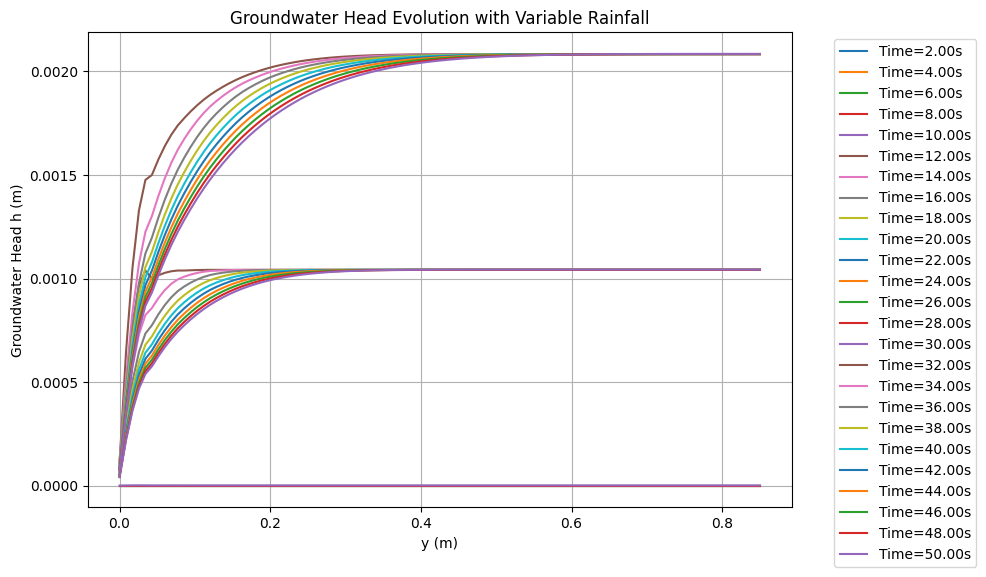

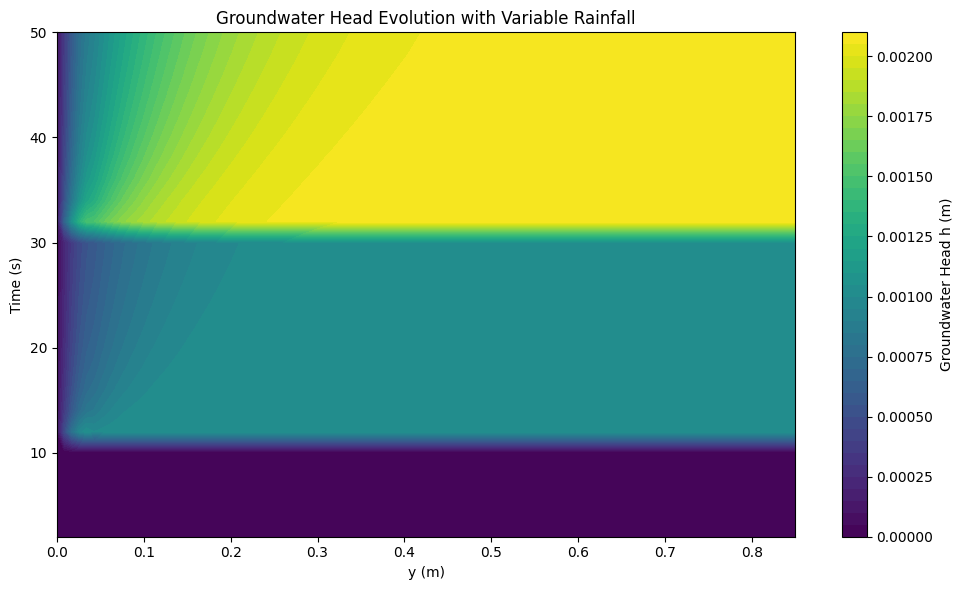

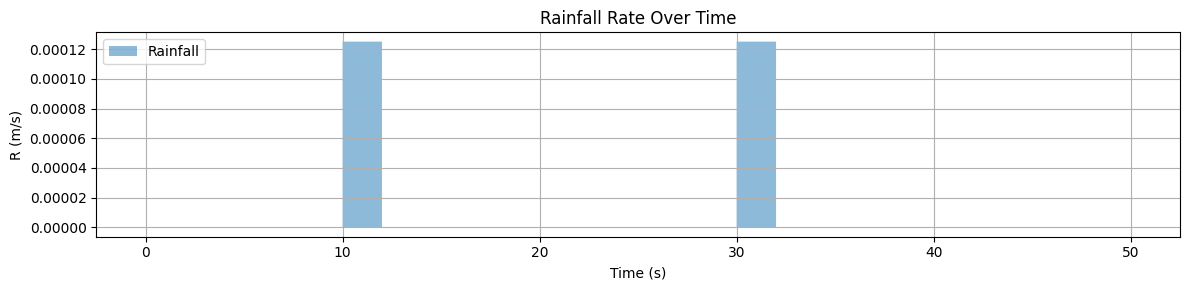

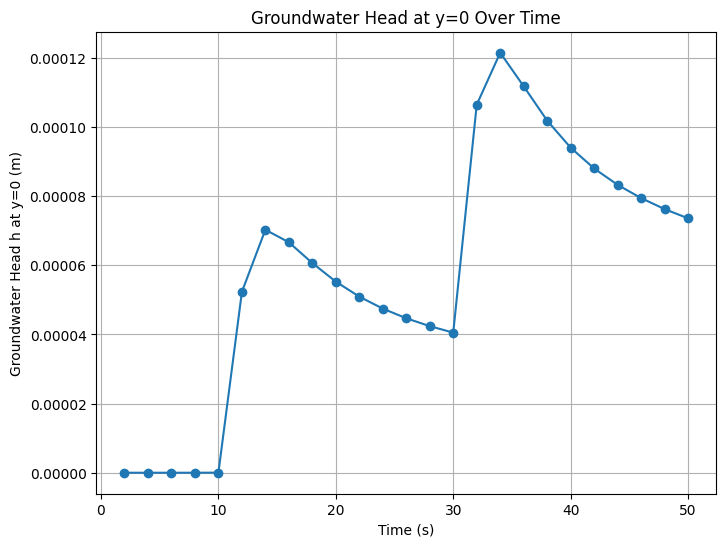

In [31]:
# Plot results
import matplotlib.pyplot as plt

# Line plots at different times
plt.figure(figsize=(10, 6))
for i in range(len(times_var)):
    plt.plot(ys_var, values_var[i], label=f'Time={times_var[i]:.2f}s')
plt.xlabel('y (m)')
plt.ylabel('Groundwater Head h (m)')
plt.title('Groundwater Head Evolution with Variable Rainfall')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

# Heatmap
plt.figure(figsize=(10, 6))
Y, T = np.meshgrid(ys_var, times_var)
Z = np.array(values_var)
plt.contourf(Y, T, Z, levels=50, cmap='viridis')
plt.colorbar(label='Groundwater Head h (m)')
plt.xlabel('y (m)')
plt.ylabel('Time (s)')
plt.title('Groundwater Head Evolution with Variable Rainfall')
plt.tight_layout()
plt.show()

# Rainfall history
plt.figure(figsize=(12, 3))
time_steps = np.arange(len(Rs_var)) * Dt
plt.fill_between(time_steps, 0, Rs_var, step='post', alpha=0.5, label='Rainfall')
plt.xlabel('Time (s)')
plt.ylabel('R (m/s)')
plt.title('Rainfall Rate Over Time')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Plot just the state at y = 0 through time
plt.figure(figsize=(8, 6))
h_at_y0 = [value[0] for value in values_var]
plt.plot(times_var, h_at_y0, marker='o')
plt.xlabel('Time (s)')
plt.ylabel('Groundwater Head h at y=0 (m)')
plt.title('Groundwater Head at y=0 Over Time')
plt.grid()
plt.show()